In [43]:
import sys
import wfdb
import os
import matplotlib.pyplot as plt
from wfdb import processing 
from analyse.utils.download_db import get_db
import numpy as np

sys.path.append('../../')

Record 00735 is too short
Record 03665 is too short


(array([[-0.275, -0.21 ],
       [-0.295, -0.2  ],
       [-0.31 , -0.22 ],
       ...,
       [-0.3  , -0.165],
       [-0.265, -0.125],
       [-0.225, -0.105]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(9, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[  53  200  350  584  729  873 1111 1260 1408 1643]


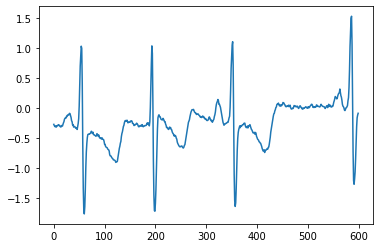

(array([[-0.415, -0.395],
       [-0.415, -0.26 ],
       [-0.43 , -0.185],
       ...,
       [-0.41 , -0.105],
       [-0.41 , -0.1  ],
       [-0.41 , -0.105]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(15, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 136  275  415  557  695  834  975 1115 1253 1399]


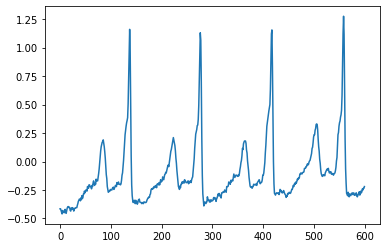

(array([[-0.375, -0.125],
       [-0.38 , -0.11 ],
       [-0.375, -0.105],
       ...,
       [-0.41 , -0.19 ],
       [-0.43 , -0.185],
       [-0.415, -0.175]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(12, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 135  352  569  778  989 1204 1419 1632 1845 2057]


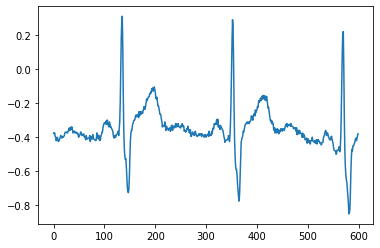

(array([[-0.04 , -0.235],
       [-0.055, -0.21 ],
       [-0.06 , -0.21 ],
       ...,
       [-0.18 , -0.24 ],
       [-0.17 , -0.255],
       [-0.16 , -0.25 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(11, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 111  309  505  700  892 1085 1288 1497 1706 1905]


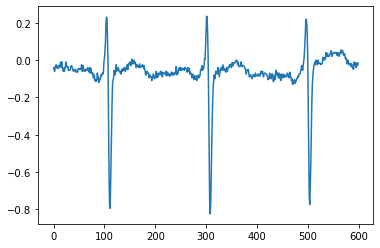

(array([[-0.285, -0.34 ],
       [-0.3  , -0.32 ],
       [-0.31 , -0.325],
       ...,
       [-0.075, -0.425],
       [-0.07 , -0.43 ],
       [-0.07 , -0.42 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(22, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 124  356  583  808 1033 1262 1499 1733 1964 2202]


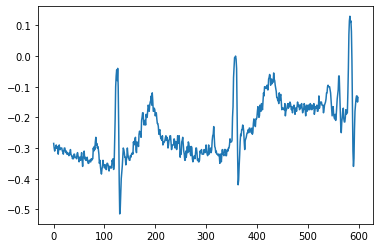

(array([[ 0.   , -0.055],
       [-0.025, -0.055],
       [-0.02 , -0.105],
       ...,
       [ 0.21 ,  0.26 ],
       [ 0.18 ,  0.185],
       [ 0.17 ,  0.05 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(15, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 198  357  512  663  812  964 1119 1277 1434 1586]


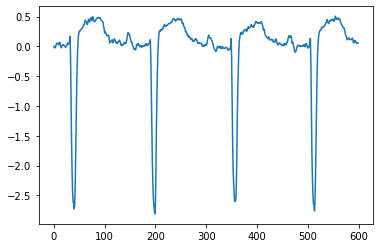

(array([[-0.015, -0.32 ],
       [-0.045, -0.35 ],
       [-0.03 , -0.345],
       ...,
       [-0.03 , -0.575],
       [-0.015, -0.53 ],
       [-0.02 , -0.48 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[  85  309  529  742  963 1185 1398 1611 1827 2048]


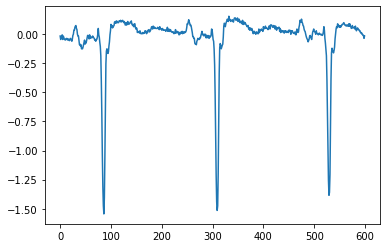

(array([[-0.13 , -0.095],
       [-0.13 , -0.095],
       [-0.115, -0.115],
       ...,
       [-0.31 , -0.57 ],
       [-0.325, -0.555],
       [-0.32 , -0.555]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(11, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 159  402  651  912 1161 1411 1664 1922 2174 2419]


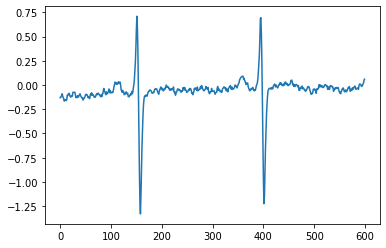

(array([[ 0.045, -0.275],
       [ 0.07 , -0.3  ],
       [ 0.1  , -0.235],
       ...,
       [ 0.125, -0.35 ],
       [ 0.11 , -0.33 ],
       [ 0.1  , -0.32 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(16, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[  55  242  440  632  823 1018 1211 1403 1601 1792]


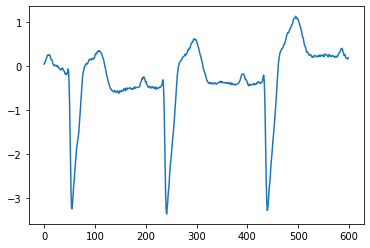

(array([[-0.635, -0.185],
       [-0.54 , -0.03 ],
       [-0.395, -0.055],
       ...,
       [-0.515,  0.16 ],
       [-0.515,  0.165],
       [-0.495,  0.155]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(12, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 209  417  626  843  979 1263 1413 1698 1844 2124]


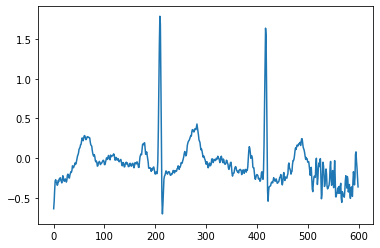

(array([[-0.055,  0.13 ],
       [-0.07 ,  0.075],
       [-0.09 ,  0.09 ],
       ...,
       [-0.18 ,  0.64 ],
       [-0.215,  0.59 ],
       [-0.225,  0.57 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(9, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[  74  221  359  478  601  725  854 1057 1194 1336]


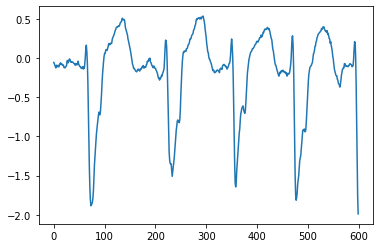

(array([[-0.075,  0.2  ],
       [-0.07 ,  0.185],
       [-0.09 ,  0.17 ],
       ...,
       [-0.22 ,  0.1  ],
       [-0.21 ,  0.08 ],
       [-0.25 ,  0.075]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(20, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[  88  290  493  703  909 1107 1312 1520 1723 1929]


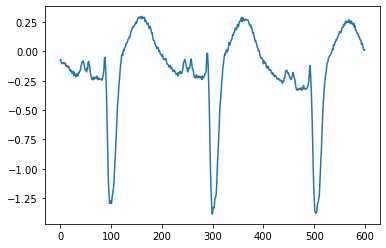

(array([[-0.26 ,  0.095],
       [-0.275,  0.1  ],
       [-0.25 ,  0.09 ],
       ...,
       [-0.225, -0.06 ],
       [-0.245, -0.045],
       [-0.265, -0.03 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(12, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 174  353  510  689  845  983 1173 1352 1534 1721]


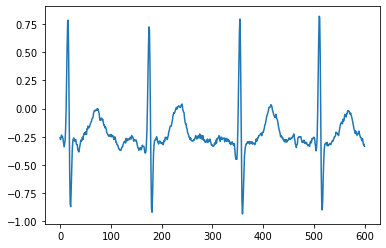

(array([[-0.085, -0.155],
       [-0.09 , -0.155],
       [-0.085, -0.155],
       ...,
       [-0.055, -0.07 ],
       [-0.04 , -0.08 ],
       [-0.035, -0.08 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(18, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 126  294  579  785 1024 1249 1492 1739 2020 2196]


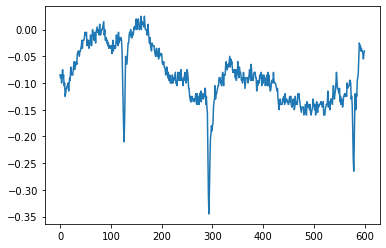

(array([[-0.05 , -0.14 ],
       [-0.03 , -0.12 ],
       [ 0.   , -0.095],
       ...,
       [ 0.1  , -0.09 ],
       [ 0.1  , -0.08 ],
       [ 0.11 , -0.085]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(9, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 148  228  285  432  587  717  847  970 1099 1237]


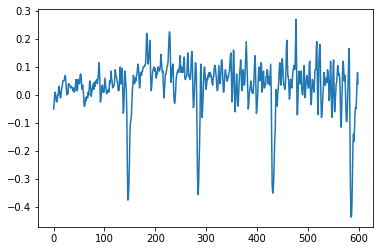

(array([[-0.01 , -0.16 ],
       [ 0.   , -0.16 ],
       [-0.015, -0.14 ],
       ...,
       [ 0.085, -0.14 ],
       [ 0.08 , -0.14 ],
       [ 0.095, -0.105]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(22, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 107  356  567  817 1020 1266 1470 1716 1920 2172]


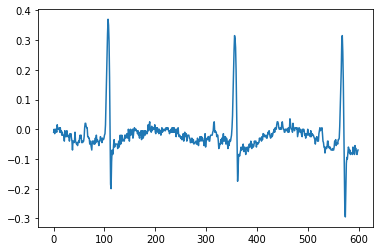

(array([[-0.16 ,  0.025],
       [-0.155,  0.015],
       [-0.15 ,  0.015],
       ...,
       [-0.175,  0.08 ],
       [-0.125,  0.08 ],
       [-0.055,  0.12 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(13, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 207  465  724  984 1243 1502 1762 2023 2283 2542]


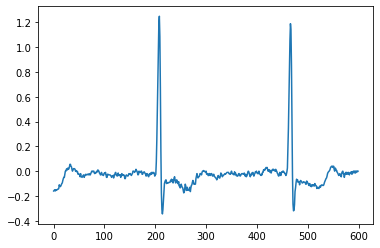

(array([[-0.725,  0.74 ],
       [-0.905,  0.715],
       [-0.88 ,  0.565],
       ...,
       [ 0.785, -1.03 ],
       [ 0.785, -1.05 ],
       [ 0.775, -1.02 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(16, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 318  518  704  886 1067 1370 1570 1751 1930 2110]


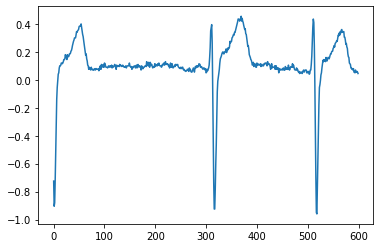

(array([[-0.265, -0.395],
       [-0.26 , -0.345],
       [-0.265, -0.3  ],
       ...,
       [ 0.03 , -0.375],
       [ 0.04 , -0.38 ],
       [ 0.05 , -0.4  ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(20, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[  54  207  356  502  594  770  925 1017 1192 1337]


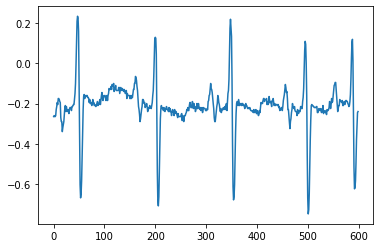

(array([[-2.255, -2.05 ],
       [-2.22 , -1.945],
       [-2.05 , -1.76 ],
       ...,
       [ 0.24 , -0.02 ],
       [ 0.25 ,  0.015],
       [ 0.305,  0.03 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 187  395  592  789  988 1187 1388 1591 1794 1997]


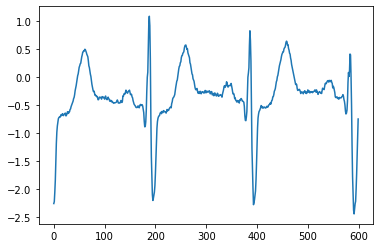

(array([[-1.285,  0.24 ],
       [ 0.42 ,  0.28 ],
       [ 1.35 ,  0.41 ],
       ...,
       [-0.48 ,  0.04 ],
       [-0.47 , -0.005],
       [-0.37 ,  0.065]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 144  340  447  722  915 1101 1288 1480 1669 1859]


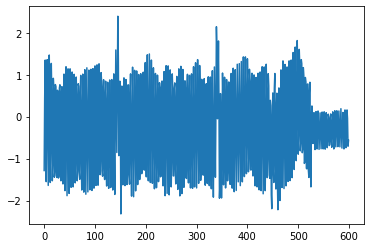

(array([[-0.24 , -0.24 ],
       [-0.26 , -0.235],
       [-0.24 , -0.23 ],
       ...,
       [-0.035, -0.08 ],
       [-0.03 , -0.095],
       [-0.005, -0.115]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(20, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 109  318  526  729  939 1145 1348 1555 1762 1966]


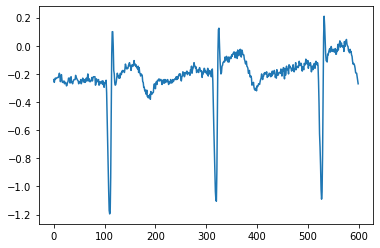

(array([[-0.275, -0.37 ],
       [-0.245, -0.45 ],
       [-0.305, -0.43 ],
       ...,
       [-0.475, -0.25 ],
       [-0.41 , -0.25 ],
       [-0.345, -0.27 ]]), {'fs': 250, 'sig_len': 2000000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []})
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 193  391  586  782  905 1179 1378 1578 1778 1977]


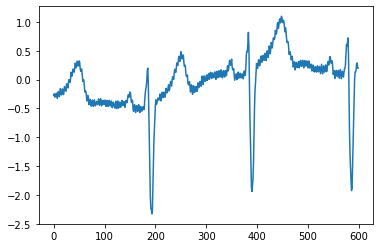

In [57]:
url = "https://physionet.org/static/published-projects/afdb/mit-bih-atrial-fibrillation-database-1.0.0.zip"
name = "mit-bih"

db_path = get_db(url, name, "../../analyse/data/")

all_records = f'{db_path}/RECORDS'
for rec in open(all_records, "r"):
    rec = rec.replace('\n', '')
    try:
        len = 2000000
        record = wfdb.rdsamp(f"{db_path}/{rec}", sampto=len)
        print(record)
        print(processing.xqrs_detect(sig=record[0][:, 0], fs=record[1]['fs'])[:10])
        plt.plot(record[0][:, 0][:600])
        plt.show()
    except ValueError:
        print(f"Record {rec} is too short", file=sys.stderr)